<h2>Real or Not? NLP with Disaster Tweets</h2>

<p>This notebook consists of different word embedding and classification models, and evaluation on each combination with its insights. The data used is <a href="https://www.kaggle.com/c/nlp-getting-started/data">Disaster Tweets</a> from Kaggle Competition.</p>

In [1]:
import gc
import string
import operator
from collections import defaultdict
from wordcloud import STOPWORDS
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dropout, Input, Embedding, LSTM
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import string
import re

In [3]:
df_clean = pd.read_csv('data/clean.csv', dtype={'id': np.int16, 'target': np.int8})

In [4]:
df_clean.head(5)

,id,text,target
0,1,Our Deeds are the Reason of this earthquake Ma...,1
1,4,Forest fire near La Ronge Sask Canada,1
2,5,All residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,Just got sent this photo from Ruby Alaska as s...,1


<h3>Recurrent Neural Network</h3>
<br>This section consists of two types of recurrent neural network (RNN): </br>
<br>Long short-term memory (LSTM) and Bidirectional Encoder Representations from Transformers (BERT)</br>

<h4>Long short-term memory (LSTM)</h4>

In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 30000
# Max number of words in each tweet
MAX_SEQUENCE_LENGTH = 1000
# Number of embedding dimensions (projection)
EMBEDDING_DIM = 100

# Additional tokenization 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_clean['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18468 unique tokens.


In [31]:
# Parse reviews' text to embedding vectors 
X = tokenizer.texts_to_sequences(df_clean['text'].values)
X = sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
Y = df_clean['target'].values

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (7613, 1000)
Shape of label tensor: (7613,)


In [32]:
# Split training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6851, 1000) (6851,)
(762, 1000) (762,)


In [33]:
# set up RNN structure
def SetupModel():    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) #LSTM layer
    model.add(Dense(1, activation='sigmoid'))
    return(model)

# set up number of epoches batch size
epochs = 5
batch_size = 32

In [34]:
SetupModel().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         3000000   
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 3,080,501
Trainable params: 3,080,501
Non-trainable params: 0
_________________________________________________________________


In [35]:
# adjust the hyper-parameters of Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# compile model and fit the training set
model_adam = SetupModel()
model_adam.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

history_adam = model_adam.fit(X_train, Y_train, 
                    epochs=epochs, batch_size=batch_size, validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 6165 samples, validate on 686 samples
Epoch 1/5
6165/6165 [==============================] - 153s 25ms/sample - loss: 0.5489 - accuracy: 0.7187 - val_loss: 0.4468 - val_accuracy: 0.7930
Epoch 2/5
6165/6165 [==============================] - 150s 24ms/sample - loss: 0.3337 - accuracy: 0.8594 - val_loss: 0.4465 - val_accuracy: 0.8047
Epoch 3/5
6165/6165 [==============================] - 152s 25ms/sample - loss: 0.2011 - accuracy: 0.9231 - val_loss: 0.5386 - val_accuracy: 0.7930
Epoch 4/5
6165/6165 [==============================] - 151s 24ms/sample - loss: 0.1307 - accuracy: 0.9551 - val_loss: 0.6120 - val_accuracy: 0.7813
Epoch 5/5
6165/6165 [==============================] - 150s 24ms/sample - loss: 0.0919 - accuracy: 0.9684 - val_loss: 0.6338 - val_accuracy: 0.7784


In [38]:
# evaluate the result
### overall
score_train_adam = model_adam.evaluate(X_train,Y_train,verbose=0)
score_test_adam = model_adam.evaluate(X_test,Y_test,verbose=0)

# training/testing acc/loss
loss_train_adam = score_train_adam[0]
loss_test_adam = score_test_adam[0]
acc_train_adam = score_train_adam[1]
acc_test_adam = score_test_adam[1]

### epoch wise
train_acc_trend_adam = history_adam.history['accuracy']
train_loss_trend_adam = history_adam.history['loss']
val_acc_trend_adam = history_adam.history['val_accuracy']
val_loss_trend_adam = history_adam.history['val_loss']

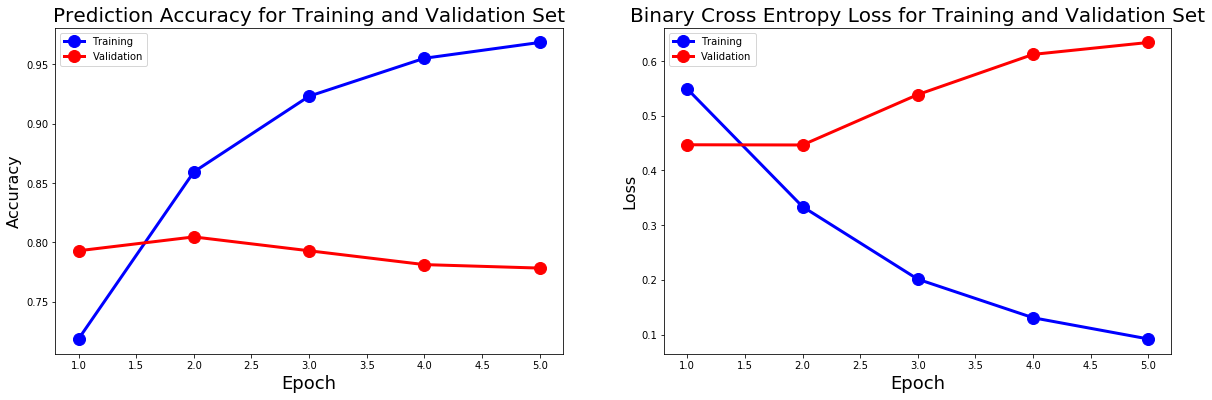

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

#### accuarcy
result_acc_train = pd.DataFrame({
    'x':range(1,6),
    'Training': train_acc_trend_adam,
    'Validation': val_acc_trend_adam
    })

ax1.plot('x', 'Training', data=result_acc_train, marker='o', color='blue', linewidth=3,markersize=12)
ax1.plot('x', 'Validation', data=result_acc_train, marker='o', color='red', linewidth=3,markersize=12)
ax1.set_title('Prediction Accuracy for Training and Validation Set', fontsize=20)
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Accuracy', fontsize=16)
ax1.legend(fontsize = 10)


#### loss
result_loss_train = pd.DataFrame({
    'x':range(1,6),
    'Training': train_loss_trend_adam,
    'Validation': val_loss_trend_adam
    })

ax2.plot('x', 'Training', data=result_loss_train, marker='o', color='blue', linewidth=3,markersize=12)
ax2.plot('x', 'Validation', data=result_loss_train, marker='o', color='red', linewidth=3,markersize=12)
ax2.set_title('Binary Cross Entropy Loss for Training and Validation Set', fontsize=20)
ax2.set_xlabel('Epoch', fontsize=18)
ax2.set_ylabel('Loss', fontsize=16)
ax2.legend(fontsize = 10)

<b>ROC Curve</b>

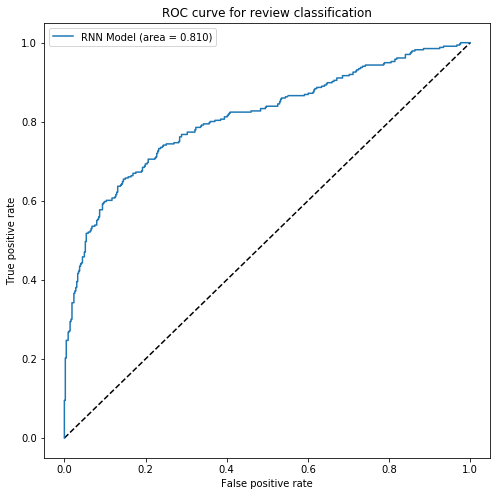

In [40]:
from sklearn.metrics import roc_curve
y_pred_keras = model_adam.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='RNN Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for review classification')
plt.legend(loc='best')
plt.show()

<h4>Bidirectional Encoder Representations from Transformers (BERT)</h4>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import tokenization

In [5]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [6]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [7]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [8]:
train,text = train_test_split(df_clean, test_size = 0.10, random_state = 42)

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [10]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

<img src="img/BERT_Summery.png" alt="BERT Summary" align="left">

In [12]:
# Train BERT model with my tuning
checkpoint = ModelCheckpoint('model_BERT.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split = valid,
    epochs = epochs_num, # recomended 3-5 epochs
    callbacks=[checkpoint],
    batch_size = batch_size_num
)

<img src="img/BERT_Training.png" alt="BERT Log" align="left">